In [5]:
import pandas as pd

# Load your cleaned or merged CSV
df = pd.read_csv("merged_jobs.csv")

# Inspect columns
print(df.columns)

cutoff_year = 2000

df = df[df["start_year"] >= cutoff_year]




Index(['position', 'start_year', 'end_year', 'skills'], dtype='object')


In [6]:
import ast

# Convert stringified lists into Python lists (if necessary)
if isinstance(df.loc[0, "skills"], str):
    df["skills"] = df["skills"].apply(lambda x: ast.literal_eval(x))


In [7]:
from sentence_transformers import SentenceTransformer
import numpy as np

# Load the model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Flatten all unique skills
all_skills = list(set([skill for skills in df["skills"] for skill in skills]))

# Generate embeddings
embeddings = model.encode(all_skills)


c:\Users\shery\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
from sklearn.cluster import KMeans

num_clusters = 50  # adjust based on your dataset size
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(embeddings)

# Map each skill to its cluster
skill_to_cluster = dict(zip(all_skills, clusters))


In [9]:
# Example: replace each skill in a row with its cluster
df["skills_clustered"] = df["skills"].apply(lambda skills: [skill_to_cluster[s] for s in skills])


In [10]:
rows = []

for _, row in df.iterrows():
    clusters = row["skills_clustered"]  # <- use the correct column
    if not isinstance(clusters, list) or len(clusters) == 0:
        continue
    
    try:
        start = int(row["start_year"])
        end = int(row["end_year"])
    except:
        continue
    
    for year in range(start, end + 1):
        for cluster_id in clusters:
            rows.append({
                "position": row["position"],
                "year": year,
                "skill_cluster": cluster_id
            })

df_cluster_year = pd.DataFrame(rows)
trend_counts = df_cluster_year.groupby(["year", "skill_cluster"]).size().reset_index(name="count")


In [ ]:
df_cluster_year.head()

In [11]:
from collections import Counter
import pandas as pd

# Build a reverse mapping: cluster -> all skills in it
cluster_to_skills = {}
for skill, cluster_id in skill_to_cluster.items():
    cluster_to_skills.setdefault(cluster_id, []).append(skill)

# Pick the top 3 most frequent skills in each cluster
cluster_labels = {}
for cluster_id, skills in cluster_to_skills.items():
    # Count frequency of each skill in the dataset
    skill_counts = Counter([s for row_skills in df["skills"] for s in row_skills if skill_to_cluster[s] == cluster_id])
    top_skills = [s for s, _ in skill_counts.most_common(3)]
    cluster_labels[cluster_id] = ", ".join(top_skills)

trend_counts["skill_label"] = trend_counts["skill_cluster"].map(cluster_labels)


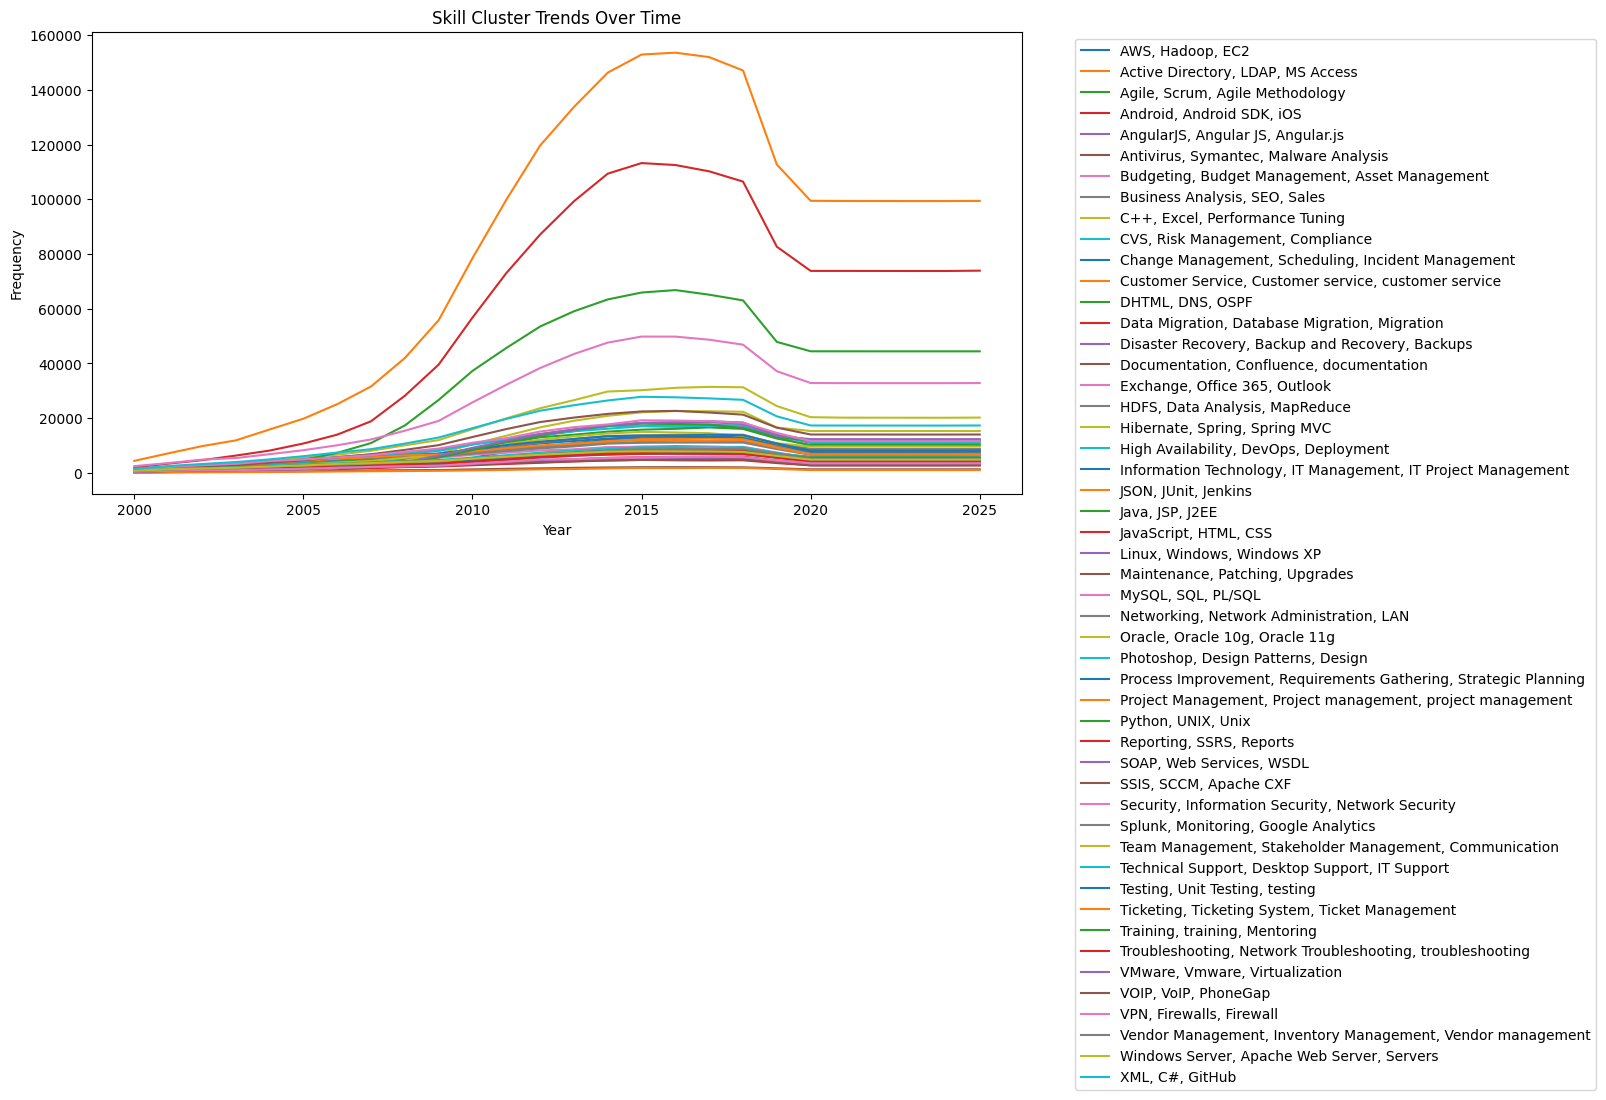

In [22]:
import matplotlib.pyplot as plt

trend_pivot = trend_counts.pivot(index="year", columns="skill_label", values="count").fillna(0)

# Create the plot and get the axes
ax = trend_pivot.plot(figsize=(12, 6))

# Customize
ax.set_title("Skill Cluster Trends Over Time")
ax.set_xlabel("Year")
ax.set_ylabel("Frequency")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # legend outside plot

# Save the figure
fig = ax.get_figure()  # get the figure from axes
fig.savefig("skill_trends.png", dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
'''
import matplotlib.pyplot as plt

trend_pivot = trend_counts.pivot(index="year", columns="skill_cluster", values="count").fillna(0)
trend_pivot.plot(figsize=(12,6))
plt.title("Skill Cluster Trends Over Time")
plt.xlabel("Year")
plt.ylabel("Frequency")
plt.show()
'''


In [15]:
trend_counts["skill_label"] = trend_counts["skill_cluster"].map(cluster_labels)
trend_counts.head()

,year,skill_cluster,count,skill_label
0,2000,0,522,"Java, JSP, J2EE"
1,2000,1,449,"Splunk, Monitoring, Google Analytics"
2,2000,2,361,"Testing, Unit Testing, testing"
3,2000,3,427,"VPN, Firewalls, Firewall"
4,2000,4,1022,"HDFS, Data Analysis, MapReduce"


In [18]:
trend_counts_role = df_cluster_year.groupby(["year", "position", "skill_cluster"]).size().reset_index(name="count")
trend_counts_role["skill_label"] = trend_counts_role["skill_cluster"].map(cluster_labels)

trend_counts_role.head()


,year,position,skill_cluster,count,skill_label
0,2000,.Net Developer & Trainee Engineer,6,1,"Vendor Management, Inventory Management, Vendo..."
1,2000,.Net Developer & Trainee Engineer,9,4,"C++, Excel, Performance Tuning"
2,2000,.Net Developer & Trainee Engineer,13,2,"Project Management, Project management, projec..."
3,2000,.Net Developer & Trainee Engineer,14,4,"Team Management, Stakeholder Management, Commu..."
4,2000,.Net Developer & Trainee Engineer,15,2,"JSON, JUnit, Jenkins"


In [19]:
trend_counts_role[trend_counts_role["position"] == "Data Scientist"]


,year,position,skill_cluster,count,skill_label
460760,2011,Data Scientist,4,3,"HDFS, Data Analysis, MapReduce"
460761,2011,Data Scientist,5,3,"Linux, Windows, Windows XP"
460762,2011,Data Scientist,7,3,"MySQL, SQL, PL/SQL"
460763,2011,Data Scientist,9,1,"C++, Excel, Performance Tuning"
460764,2011,Data Scientist,10,2,"AWS, Hadoop, EC2"
...,...,...,...,...,...
1886182,2025,Data Scientist,39,1,"Ticketing, Ticketing System, Ticket Management"
1886183,2025,Data Scientist,42,1,"Training, training, Mentoring"
1886184,2025,Data Scientist,44,1,"Change Management, Scheduling, Incident Manage..."
1886185,2025,Data Scientist,47,2,"Data Migration, Database Migration, Migration"


In [20]:
trend_counts.to_csv("skill_trends.csv", index=False)
trend_counts_role.to_csv("skill_trends_by_role.csv", index=False)


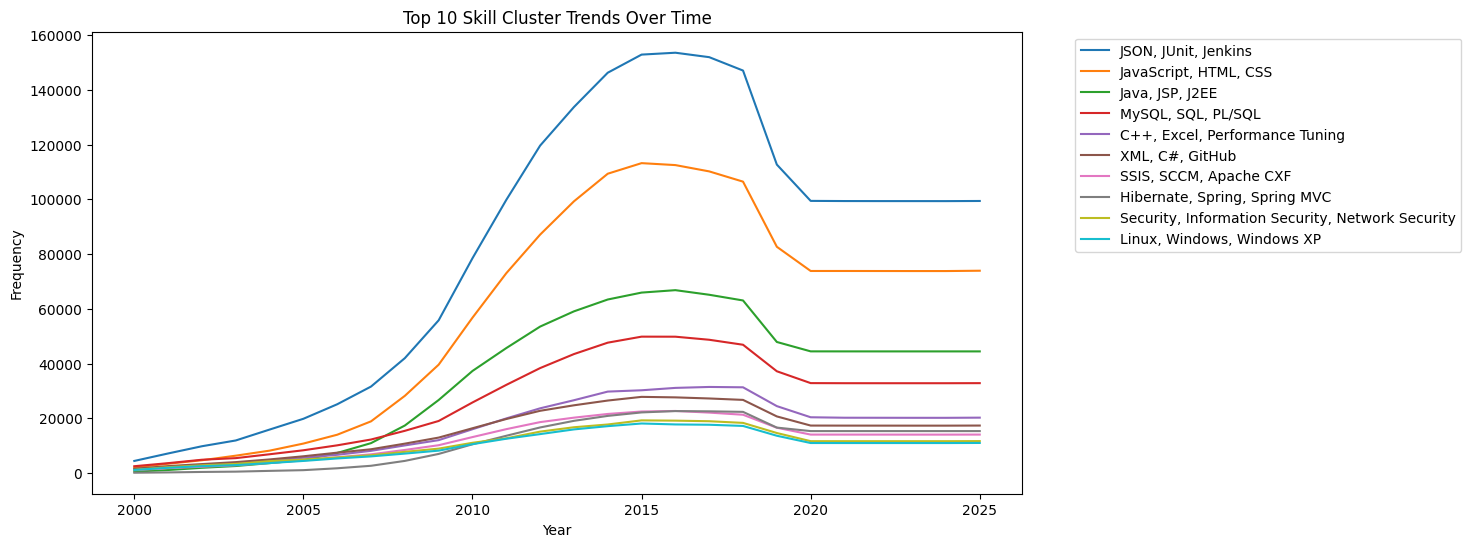

In [24]:
top_clusters = trend_counts.groupby("skill_label")["count"].sum().sort_values(ascending=False).head(10).index
trend_pivot_top = trend_pivot[top_clusters]

ax = trend_pivot_top.plot(figsize=(12,6))
ax.set_title("Top 10 Skill Cluster Trends Over Time")
ax.set_xlabel("Year")
ax.set_ylabel("Frequency")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
fig = ax.get_figure()
fig.savefig("skill_trends_top.png", dpi=300, bbox_inches='tight')
plt.show()
